In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# высокое качество графиков
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

print("Ready")

Ready


In [95]:
np.random.seed(42)

n_users = 5000
n_events = 40000

user_ids = np.random.randint(1, n_users+1, n_events)

events = np.random.choice(
    ["visit", "signup", "trial_start", "purchase"],
    size=n_events,
    p=[0.55, 0.20, 0.15, 0.10]
)

timestamps = pd.to_datetime("2024-01-01") + pd.to_timedelta(
    np.random.randint(0, 60*24*30, n_events), unit="m"
)

source = np.random.choice(
    ["ads", "organic", "email", "referral"],
    size=n_events,
    p=[0.4, 0.3, 0.2, 0.1]
)

device = np.random.choice(
    ["mobile", "desktop"],
    size=n_events,
    p=[0.7, 0.3]
)

revenue = np.where(
    events == "purchase",
    np.random.gamma(3, 20, n_events),
    0
)

df = pd.DataFrame({
    "user_id": user_ids,
    "event": events,
    "timestamp": timestamps,
    "source": source,
    "device": device,
    "revenue": revenue
})

df = df.sort_values("timestamp")
df.head()

,user_id,event,timestamp,source,device,revenue
12923,3388,purchase,2024-01-01 00:01:00,ads,desktop,39.672497
9673,4478,trial_start,2024-01-01 00:03:00,referral,mobile,0.000000
31955,1977,visit,2024-01-01 00:04:00,ads,desktop,0.000000
24613,3534,trial_start,2024-01-01 00:05:00,ads,mobile,0.000000
8461,4241,trial_start,2024-01-01 00:05:00,organic,mobile,0.000000


In [96]:
print(df.shape)
df.describe(include="all")

(40000, 6)


,user_id,event,timestamp,source,device,revenue
count,40000.00000,40000,40000,40000,40000,40000.000000
unique,NaN,4,NaN,4,2,NaN
top,NaN,visit,NaN,ads,mobile,NaN
freq,NaN,22034,NaN,15970,27713,NaN
mean,2504.86010,NaN,2024-01-15 23:32:14.130000128,NaN,NaN,6.249296
min,1.00000,NaN,2024-01-01 00:01:00,NaN,NaN,0.000000
25%,1265.00000,NaN,2024-01-08 13:16:45,NaN,NaN,0.000000
50%,2512.00000,NaN,2024-01-15 23:55:00,NaN,NaN,0.000000
75%,3737.00000,NaN,2024-01-23 10:43:30,NaN,NaN,0.000000
max,5000.00000,NaN,2024-01-30 23:57:00,NaN,NaN,242.228079


In [97]:
df.to_csv("product_events_raw.csv", index=False)

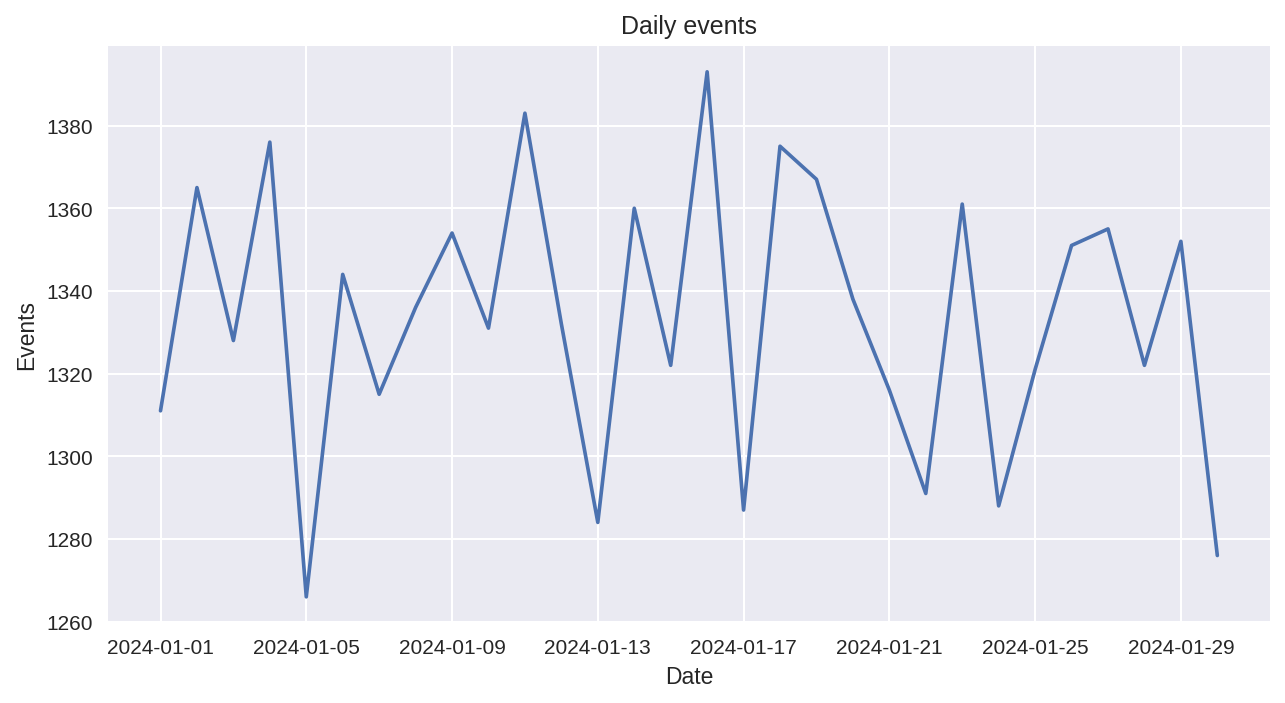

In [98]:
daily_events = (
    df
    .assign(day=df["timestamp"].dt.date)
    .groupby("day")
    .size()
)

plt.figure(figsize=(10,5))
daily_events.plot()

plt.title("Daily events")
plt.xlabel("Date")
plt.ylabel("Events")
plt.grid(True)

plt.savefig("daily_events.pdf", bbox_inches="tight")
plt.savefig("daily_events.png", bbox_inches="tight")

plt.show()

In [99]:
funnel = (
    df
    .groupby("event")["user_id"]
    .nunique()
    .reindex(["visit", "signup", "trial_start", "purchase"])
)

funnel

,user_id
event,
visit,4935
signup,3977
trial_start,3543
purchase,2800


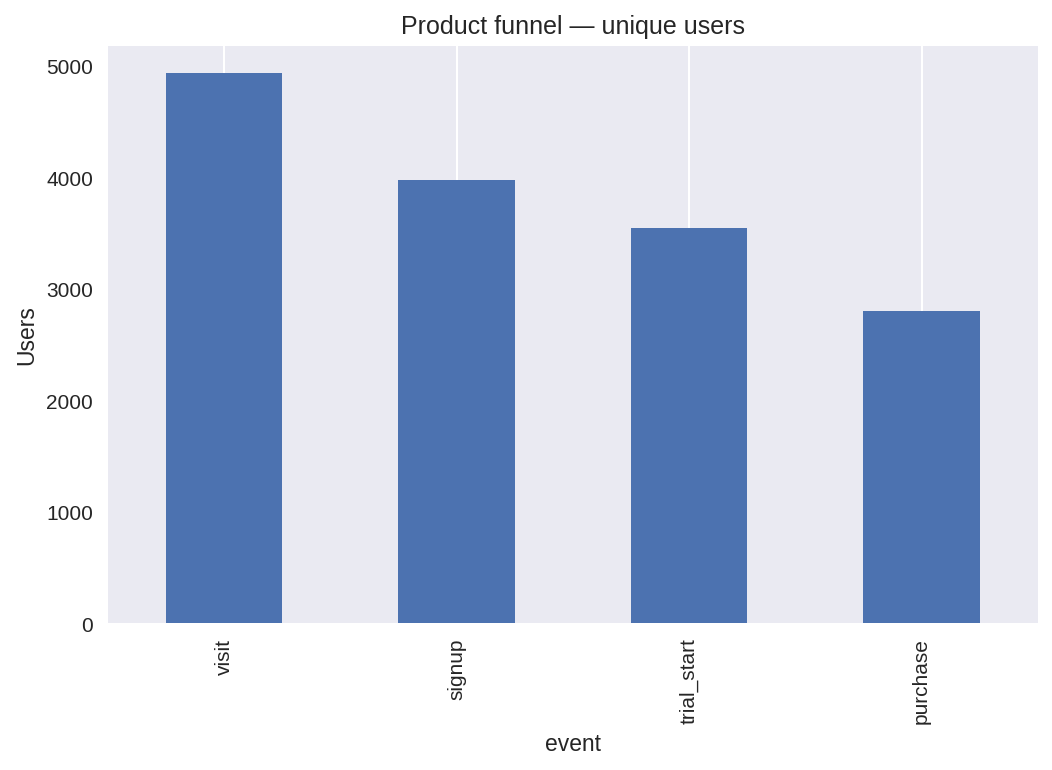

In [100]:
plt.figure(figsize=(8,5))
funnel.plot(kind="bar")

plt.title("Product funnel — unique users")
plt.ylabel("Users")
plt.grid(axis="y")

plt.savefig("funnel_users.pdf", bbox_inches="tight")
plt.savefig("funnel_users.png", bbox_inches="tight")

plt.show()

In [101]:
funnel_df = funnel.reset_index()
funnel_df.columns = ["event", "users"]

funnel_df["conversion_from_prev"] = (
    funnel_df["users"] / funnel_df["users"].shift(1)
)

funnel_df

,event,users,conversion_from_prev
0,visit,4935,NaN
1,signup,3977,0.805876
2,trial_start,3543,0.890873
3,purchase,2800,0.790291


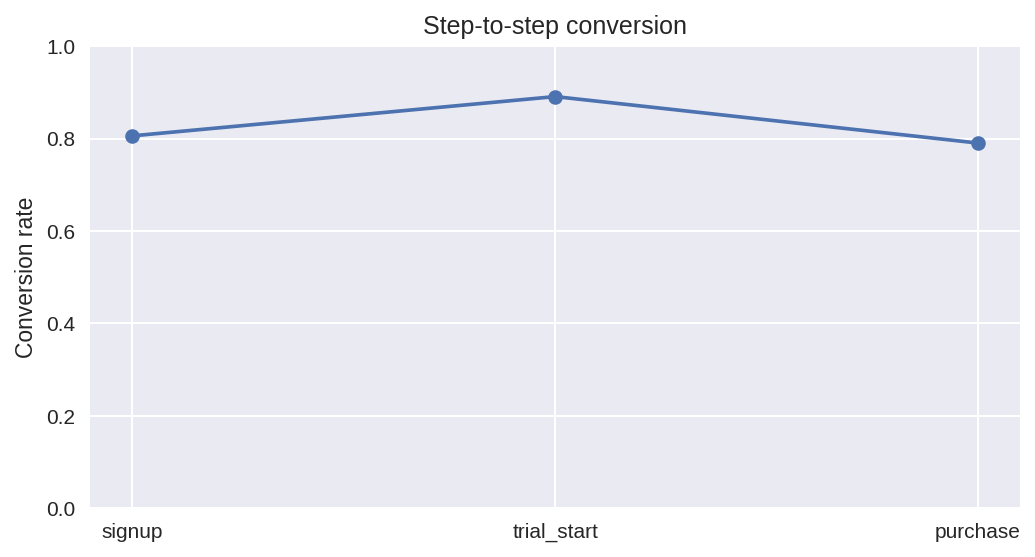

In [102]:
plt.figure(figsize=(8,4))
plt.plot(
    funnel_df["event"][1:],
    funnel_df["conversion_from_prev"][1:],
    marker="o"
)

plt.title("Step-to-step conversion")
plt.ylabel("Conversion rate")
plt.ylim(0, 1)
plt.grid(True)

plt.savefig("funnel_conversion.pdf", bbox_inches="tight")
plt.savefig("funnel_conversion.png", bbox_inches="tight")
plt.show()

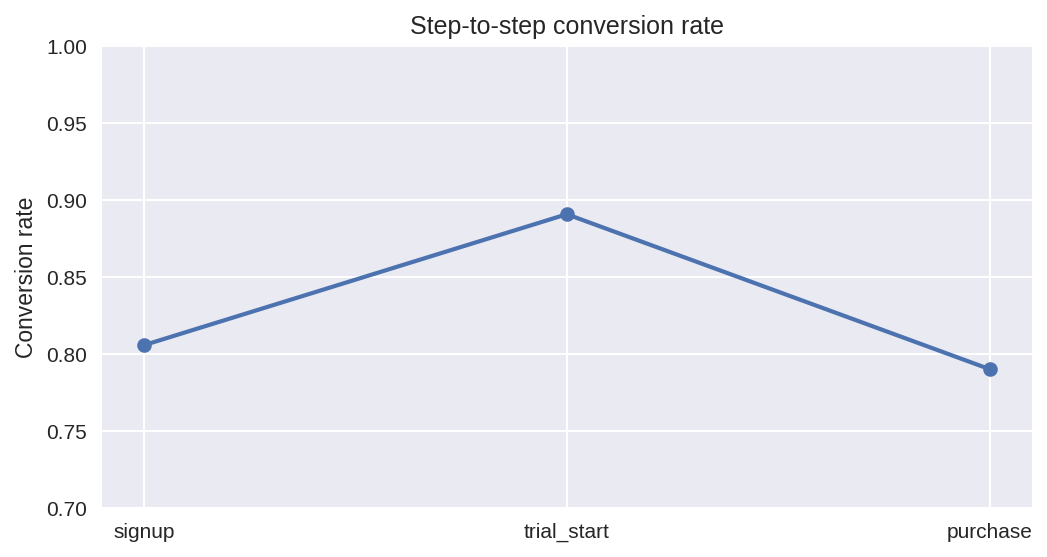

In [103]:
plot_df = funnel_df.dropna()

plt.figure(figsize=(8,4))
plt.plot(
    plot_df["event"],
    plot_df["conversion_from_prev"],
    marker="o",
    linewidth=2
)

plt.title("Step-to-step conversion rate")
plt.ylabel("Conversion rate")
plt.ylim(0.7, 1.0)
plt.grid(True)

plt.savefig("funnel_conversion.pdf", bbox_inches="tight")
plt.savefig("funnel_conversion.png", bbox_inches="tight", dpi=200)
plt.show()

In [104]:
funnel_by_source = (
    df
    .groupby(["source", "event"])["user_id"]
    .nunique()
    .unstack()
    [["visit", "signup", "trial_start", "purchase"]]
)

funnel_by_source

event,visit,signup,trial_start,purchase
source,,,,
ads,4190,2319,1919,1385
email,2891,1298,1113,722
organic,3668,1876,1557,1125
referral,1822,738,548,392


In [105]:
conversion_by_source = funnel_by_source.copy()

conversion_by_source["visit_to_signup"] = (
    conversion_by_source["signup"] / conversion_by_source["visit"]
)

conversion_by_source["signup_to_trial"] = (
    conversion_by_source["trial_start"] / conversion_by_source["signup"]
)

conversion_by_source["trial_to_purchase"] = (
    conversion_by_source["purchase"] / conversion_by_source["trial_start"]
)

conversion_by_source[
    ["visit_to_signup", "signup_to_trial", "trial_to_purchase"]
]

event,visit_to_signup,signup_to_trial,trial_to_purchase
source,,,
ads,0.553461,0.827512,0.721730
email,0.448980,0.857473,0.648697
organic,0.511450,0.829957,0.722543
referral,0.405049,0.742547,0.715328
